In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
# Make sure we are able to handle large datasets
# Make sure we are able to handle large datasets
import resource

low, high = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (high, high))

import math
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import ops
from keras import layers
from src.vision_transformer import PatchEmbed
from src.pos_embed import get_2d_sincos_pos_embed

from source.callbacks import cosine_schedule
from tensorflow.keras.callbacks import LearningRateScheduler

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    
    except RuntimeError as e:
        print(e)

2024-08-26 10:20:40.373309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 10:20:40.387637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 10:20:40.391996: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 10:20:40.402915: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 10:20:41.134262: W tensorflow/comp

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


2024-08-26 10:20:42.057254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22279 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:17:00.0, compute capability: 8.9


batch size is 121 (unlabeled) + 6 (labeled)


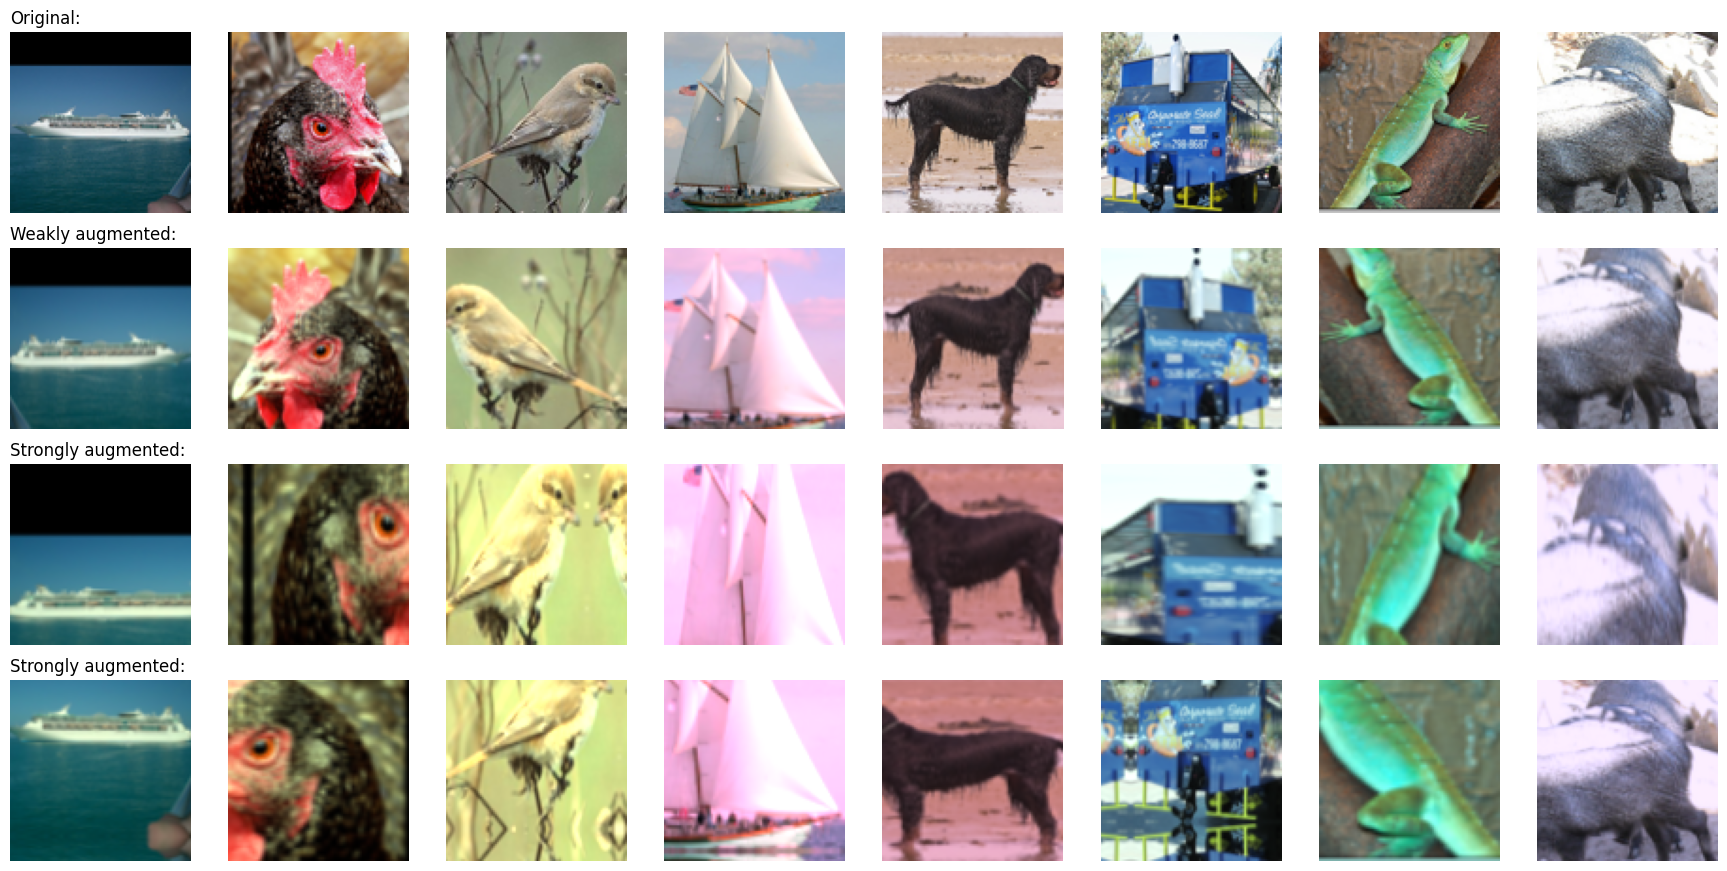

In [2]:
"""
## Hyperparameter setup
"""
# Dataset hyperparameters
unlabeled_dataset_size = 100000
labeled_dataset_size = 5000
image_channels = 3

# Algorithm hyperparameters
num_epochs = 20
batch_size = 128  # Corresponds to 200 steps per epoch
width = 128
temperature = 0.1
# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {
    "min_area": 0.75,
    "brightness": 0.3,
    "jitter": 0.1,
}

"""
## Dataset

During training we will simultaneously load a large batch of unlabeled images along with a
smaller batch of labeled images.
"""


def prepare_dataset():
    # Labeled and unlabeled samples are loaded synchronously
    # with batch sizes selected accordingly
    steps_per_epoch = (unlabeled_dataset_size + labeled_dataset_size) // batch_size
    unlabeled_batch_size = unlabeled_dataset_size // steps_per_epoch
    labeled_batch_size = labeled_dataset_size // steps_per_epoch
    print(
        f"batch size is {unlabeled_batch_size} (unlabeled) + {labeled_batch_size} (labeled)"
    )

    # Turning off shuffle to lower resource usage
    unlabeled_train_dataset = (
        tfds.load("stl10", split="unlabelled", as_supervised=True, shuffle_files=False)
        .shuffle(buffer_size=10 * unlabeled_batch_size)
        .batch(unlabeled_batch_size)
    )
    labeled_train_dataset = (
        tfds.load("stl10", split="train", as_supervised=True, shuffle_files=False)
        .shuffle(buffer_size=10 * labeled_batch_size)
        .batch(labeled_batch_size)
    )
    test_dataset = (
        tfds.load("stl10", split="test", as_supervised=True)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    # Labeled and unlabeled datasets are zipped together
    train_dataset = tf.data.Dataset.zip(
        (unlabeled_train_dataset, labeled_train_dataset)
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, labeled_train_dataset, test_dataset


# Load STL10 dataset
train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

"""
## Image augmentations

The two most important image augmentations for contrastive learning are the
following:

- Cropping: forces the model to encode different parts of the same image
similarly, we implement it with the
[RandomTranslation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_translation/)
and
[RandomZoom](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_zoom/)
layers
- Color jitter: prevents a trivial color histogram-based solution to the task by
distorting color histograms. A principled way to implement that is by affine
transformations in color space.

In this example we use random horizontal flips as well. Stronger augmentations
are applied for contrastive learning, along with weaker ones for supervised
classification to avoid overfitting on the few labeled examples.

We implement random color jitter as a custom preprocessing layer. Using
preprocessing layers for data augmentation has the following two advantages:

- The data augmentation will run on GPU in batches, so the training will not be
bottlenecked by the data pipeline in environments with constrained CPU
resources (such as a Colab Notebook, or a personal machine)
- Deployment is easier as the data preprocessing pipeline is encapsulated in the
model, and does not have to be reimplemented when deploying it
"""


# Distorts the color distibutions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.seed_generator = keras.random.SeedGenerator(1337)
        self.brightness = brightness
        self.jitter = jitter

    def get_config(self):
        config = super().get_config()
        config.update({"brightness": self.brightness, "jitter": self.jitter})
        return config

    def call(self, images, training=True):
        if training:
            batch_size = ops.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + keras.random.uniform(
                (batch_size, 1, 1, 1),
                minval=-self.brightness,
                maxval=self.brightness,
                seed=self.seed_generator,
            )
            # Different for all colors
            jitter_matrices = keras.random.uniform(
                (batch_size, 1, 3, 3),
                minval=-self.jitter,
                maxval=self.jitter,
                seed=self.seed_generator,
            )

            color_transforms = (
                ops.tile(ops.expand_dims(ops.eye(3), axis=0), (batch_size, 1, 1, 1))
                * brightness_scales
                + jitter_matrices
            )
            images = ops.clip(ops.matmul(images, color_transforms), 0, 1)
        return images


# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )


def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_dataset))[0][0][:num_images]

    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

In [3]:
def Encoder(embed_dim,
            num_heads,
            mlp_ratio,
            depth
           ):
    
    inputs = tf.keras.layers.Input((None, embed_dim))
    x = inputs
    for _ in range(depth):

        # Create a multi-head attention layer.  
        
        
        att = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=(embed_dim // num_heads), dropout=0.1
        )(x, x)
        
        

        # Skip connection 1.
        skip = x + att
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(skip)
        
        # Feed Forward Part
        x = tf.keras.layers.Dense(int(embed_dim*mlp_ratio), activation='gelu')(x)
        x = tf.keras.layers.Dense(embed_dim)(x)
        x = tf.keras.layers.Dropout(0.1)(x)

        # Skip connection 2.
        x = x + skip     
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

        
        
    
    model = tf.keras.Model(inputs, x, name="encoder_block")
    
    return model


def EncoderVit(embed_dim,
            num_heads,
            mlp_ratio,
            depth
           ):
    
    inputs = tf.keras.layers.Input((None, embed_dim))
    x = inputs
    for _ in range(depth):

        # Create a multi-head attention layer.  
        
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        
        att = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=(embed_dim // num_heads), dropout=0.1
        )(x, x)

        # Skip connection 1.
        skip = x + att
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(skip)
        
        # Feed Forward Part
        x = tf.keras.layers.Dense(int(embed_dim*mlp_ratio), activation='gelu')(x)
        x = tf.keras.layers.Dense(embed_dim)(x)
        x = tf.keras.layers.Dropout(0.1)(x)

        # Skip connection 2.
        x = skip + x     
        

    
    model = tf.keras.Model(inputs, x[:,0], name="encoder_block")
    
    return model

In [4]:
def patch_embed():

    inputs = tf.keras.layers.Input((96,96, 3))
    embbing_layer = PatchEmbed(img_size, 
                          patch_size, 
                          in_chans, 
                          embed_dim
                         )
    pos_embed = tf.Variable(name="pos_embed", 
                        initial_value=tf.zeros((1, embbing_layer.num_patches + 1, embed_dim)),
                        trainable=True)  # fixed sin-cos embedding

    pos_embed = tf.expand_dims(get_2d_sincos_pos_embed(pos_embed.shape[-1],
                                   int(embbing_layer.num_patches**.5), cls_token=True
                                  ), axis=0)

    x = embbing_layer(inputs)

    # add pos embed w/o cls token
    x = x + pos_embed[:, 1:, :]

    
    return tf.keras.Model(inputs, x, name="patch_embed_block")


In [38]:
def get_encoder():
    return keras.Sequential(
        [
            layers.Input(shape=(96,96, 3)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

#lala = get_encoder()
#lala.summary()

In [5]:
def down_block(x, filters, use_maxpool = True):
    x = tf.keras.layers.Conv2D(filters, 3, padding= 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding= 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    if use_maxpool == True:
        return  tf.keras.layers.MaxPooling2D(strides= (2,2))(x), x
    else:
        return x
def up_block(x,y, filters):
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Concatenate(axis = 3)([x,y])
    x = tf.keras.layers.Conv2D(filters, 3, padding= 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding= 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x
    
def Unet(input_size=(256, 256, 1), *, classes, dropout):
    filter = [64,128,256,512, 1024]
    # encode
    Input = tf.keras.layers.Input(shape = input_size)
    x, temp1 = down_block(Input, filter[0])
    x, temp2 = down_block(x, filter[1])
    x, temp3 = down_block(x, filter[2])
    x, temp4 = down_block(x, filter[3])
    x = down_block(x, filter[4], use_maxpool= False)
    # decode 
    x = up_block(x, temp4, filter[3])
    x = up_block(x, temp3, filter[2])
    x = up_block(x, temp2, filter[1])
    x = up_block(x, temp1, filter[0])
    x = tf.keras.layers.Dropout(dropout)(x)
    x = layers.Flatten()(x)
    #output = tf.keras.layers.Conv2D(classes, 1, activation= 'softmax')(x)
    model = tf.keras.Model(Input, x, name = 'unet')
    model.summary()
    return model

In [14]:
img_size=96 
patch_size=16 
in_chans=3
embed_dim=192
depth=3
num_heads=6
mlp_ratio = 4
#_encoder = EncoderVit(embed_dim,
#                     num_heads,
##                     mlp_ratio,
#                     depth
#                     )
#embbing_layer = patch_embed()
#embbing_layer.summary()


_encoder = Unet((96,96,3), classes=10, dropout= 0.2)

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 96, 96,    │      1,792 │ input_layer_13[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_36      │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 96, 96,    │     36,928 │ leaky_re_lu_36[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_37      │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 48, 48,    │          0 │ leaky_re_lu_37[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 48, 48,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        512 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_38      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 48, 48,    │    147,584 │ leaky_re_lu_38[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        512 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_39      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 24, 24,    │          0 │ leaky_re_lu_39[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 24, 24,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │      1,024 │ conv2d_40[0][0] 

 Total params: 31,402,432 (119.79 MB)

 Trainable params: 31,390,656 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [10]:
images = next(iter(train_dataset))[0][0][:1]
x = get_augmenter(**classification_augmentation)(images)
#x = embbing_layer(x)
x = _encoder(x)
x.shape

TensorShape([1, 589824])

In [15]:
"""
## Encoder architecture
"""

# Define the encoder architecture

"""
## Supervised baseline model

A baseline supervised model is trained using random initialization.
"""

# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        keras.Input(shape=(96,96, 3)),
        get_augmenter(**classification_augmentation),
        #embbing_layer,
        _encoder,
        #layers.GlobalAveragePooling1D(),
        #layers.LayerNormalization(epsilon=1e-6),
        #layers.Dense(embed_dim, activation=tf.keras.activations.gelu),
        #layers.Dropout(0.1),
        layers.Dense(10),
    ],
    name="baseline_model",
)

In [16]:
n_epochs = 40

#Cria o diretorio de escrita
dt = time.localtime()

strinstante = "%02d-%02d-%04d-%02d-%02d-%02d" % (
dt.tm_year, dt.tm_mon, dt.tm_mday, dt.tm_hour, dt.tm_min, dt.tm_sec)

out_directory = 'ResultsSimCLR/' + '/Unet/' + "/checkpoint_ " + strinstante +  "/" + 'model'
if not os.path.exists(out_directory):
    os.makedirs(out_directory)

model_checkpoint_name = "WeightTrained-" + strinstante

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(out_directory + '/' + model_checkpoint_name + ".weights.h5", 
                                           save_best_only=True, 
                                           save_weights_only=True, 
                                           monitor="val_loss", 
                                           verbose=1
                                        ),
    #LearningRateScheduler(cosine_schedule(base_lr=1e-3, 
    #                              total_steps=n_epochs, 
    #                              warmup_steps=10))
   #,
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, mode='min'),
]



baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    labeled_train_dataset, epochs=n_epochs, validation_data=test_dataset, callbacks=callbacks,
)

Epoch 1/40


2024-08-26 15:32:05.123138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/baseline_model_1/unet_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


834/834 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - acc: 0.1715 - loss: 91.6455
Epoch 1: val_loss improved from inf to 1863.95227, saving model to ResultsSimCLR//Unet//checkpoint_ 2024-08-0026-15-31-58/model/WeightTrained-2024-08-0026-15-31-58.weights.h5
834/834 ━━━━━━━━━━━━━━━━━━━━ 51s 52ms/step - acc: 0.1716 - loss: 91.6187 - val_acc: 0.1371 - val_loss: 1863.9523
Epoch 2/40
833/834 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - acc: 0.2197 - loss: 37.2034
Epoch 2: val_loss improved from 1863.95227 to 317.91486, saving model to ResultsSimCLR//Unet//checkpoint_ 2024-08-0026-15-31-58/model/WeightTrained-2024-08-0026-15-31-58.weights.h5
834/834 ━━━━━━━━━━━━━━━━━━━━ 47s 56ms/step - acc: 0.2196 - loss: 37.1856 - val_acc: 0.2548 - val_loss: 317.9149
Epoch 3/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - acc: 0.2577 - loss: 14.5181
Epoch 3: val_loss improved from 317.91486 to 2.96677, saving model to ResultsSimCLR//Unet//checkpoint_ 2024-08-0026-15-31-58/model/WeightTrained-2024-08-0026-15-31-58.weights.h5
834

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [17]:
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Maximal validation accuracy: 59.34%


In [23]:
modelName = out_directory + '/' + model_checkpoint_name + ".weights.h5"

In [28]:
modelBest = keras.Sequential(
    [
        keras.Input(shape=(96,96, 3)),
        get_augmenter(**classification_augmentation),
        #embbing_layer,
        _encoder,
        #layers.GlobalAveragePooling1D(),
        #layers.LayerNormalization(epsilon=1e-6),
        #layers.Dense(embed_dim, activation=tf.keras.activations.gelu),
        #layers.Dropout(0.1),
        layers.Dense(10),
    ],
    name="baseline_model",
)

modelBest.load_weights(modelName)
modelBest.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

In [29]:
results = modelBest.evaluate(test_dataset, batch_size=128)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - acc: 0.5099 - loss: 1.4379


In [ ]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder =  Unet((96,96,3), classes=10, dropout= 0.2)
        
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(589824,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(589824,)), layers.Dense(10)],
            name="linear_probe",
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = ops.normalize(projections_1, axis=1)
        projections_2 = ops.normalize(projections_2, axis=1)
        similarities = (
            ops.matmul(projections_1, ops.transpose(projections_2)) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = ops.shape(projections_1)[0]
        contrastive_labels = ops.arange(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, ops.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, ops.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = ops.concatenate((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 96, 96,    │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 96, 96,    │     36,928 │ leaky_re_lu_18[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 48, 48,    │          0 │ leaky_re_lu_19[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 48, 48,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_20      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 48, 48,    │    147,584 │ leaky_re_lu_20[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_21      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 24, 24,    │          0 │ leaky_re_lu_21[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 24, 24,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │      1,024 │ conv2d_22[0][0] 

 Total params: 31,402,432 (119.79 MB)

 Trainable params: 31,390,656 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 96, 96,    │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 96, 96,    │     36,928 │ leaky_re_lu_18[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 48, 48,    │          0 │ leaky_re_lu_19[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 48, 48,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_20      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 48, 48,    │    147,584 │ leaky_re_lu_20[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_21      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 24, 24,    │          0 │ leaky_re_lu_21[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 24, 24,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │      1,024 │ conv2d_22[0][0] 

 Total params: 31,402,432 (119.79 MB)

 Trainable params: 31,390,656 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

Model: "projection_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │    75,497,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,514,112 (288.06 MB)

 Trainable params: 75,514,112 (288.06 MB)

 Non-trainable params: 0 (0.00 B)

Model: "linear_probe"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 10)             │     5,898,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,898,250 (22.50 MB)

 Trainable params: 5,898,250 (22.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2024-08-26 10:21:24.043480: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/unet_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-26 10:21:26.183944: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904
W0000 00:00:1724678486.254777    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678486.295727    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678486.296466    4123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678486.297029    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678486.300176    4123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy

  1/827 ━━━━━━━━━━━━━━━━━━━━ 5:25:39 24s/step - c_acc: 0.0472 - c_loss: 4.8459 - p_acc: 0.1667 - p_loss: 2.2745

W0000 00:00:1724678495.911452    4123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678495.911997    4123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678495.912359    4123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678495.912858    4123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678495.913188    4123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678495.913516    4123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678495.913845    4123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678495.914334    4123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678495.914836    4123 gp

826/827 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - c_acc: 0.3106 - c_loss: 3.0484 - p_acc: 0.1904 - p_loss: 1062.3671

W0000 00:00:1724678918.251190    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678918.251526    4123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678918.252003    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678918.252669    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678918.253001    4123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678918.253340    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678918.253992    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678918.254303    4123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678918.254700    4125 gp

827/827 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - c_acc: 0.3107 - c_loss: 3.0475 - p_acc: 0.1905 - p_loss: 1061.5499

W0000 00:00:1724678923.424732    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678923.425403    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678923.425992    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678923.426577    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678923.427157    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678923.427782    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678923.428422    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678923.429022    4125 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678923.429811    4125 gp

827/827 ━━━━━━━━━━━━━━━━━━━━ 458s 525ms/step - c_acc: 0.3109 - c_loss: 3.0467 - p_acc: 0.1906 - p_loss: 1060.7346 - val_p_acc: 0.4016 - val_p_loss: 84.1750
Epoch 2/20


W0000 00:00:1724678929.855081    4115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678929.857937    4115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678929.861478    4115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678929.864240    4115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678929.867033    4115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678929.869955    4115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678929.872753    4115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678929.876214    4115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724678929.880447    4115 gp

827/827 ━━━━━━━━━━━━━━━━━━━━ 427s 517ms/step - c_acc: 0.6659 - c_loss: 1.4083 - p_acc: 0.4017 - p_loss: 105.0567 - val_p_acc: 0.4703 - val_p_loss: 110.3768
Epoch 3/20
 21/827 ━━━━━━━━━━━━━━━━━━━━ 6:52 512ms/step - c_acc: 0.7523 - c_loss: 1.0651 - p_acc: 0.5350 - p_loss: 109.7987

2024-08-26 10:36:08.410398: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 44/827 ━━━━━━━━━━━━━━━━━━━━ 6:41 512ms/step - c_acc: 0.7585 - c_loss: 1.0555 - p_acc: 0.4922 - p_loss: 107.8437

2024-08-26 10:36:20.202259: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


152/827 ━━━━━━━━━━━━━━━━━━━━ 5:45 512ms/step - c_acc: 0.7603 - c_loss: 1.0574 - p_acc: 0.4651 - p_loss: 108.0878

2024-08-26 10:37:15.444914: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


155/827 ━━━━━━━━━━━━━━━━━━━━ 5:43 512ms/step - c_acc: 0.7603 - c_loss: 1.0574 - p_acc: 0.4649 - p_loss: 108.1805

2024-08-26 10:37:16.960780: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


204/827 ━━━━━━━━━━━━━━━━━━━━ 5:18 512ms/step - c_acc: 0.7607 - c_loss: 1.0574 - p_acc: 0.4617 - p_loss: 110.1078

2024-08-26 10:37:42.016783: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


273/827 ━━━━━━━━━━━━━━━━━━━━ 4:43 512ms/step - c_acc: 0.7618 - c_loss: 1.0554 - p_acc: 0.4584 - p_loss: 111.8523

2024-08-26 10:38:17.303482: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


827/827 ━━━━━━━━━━━━━━━━━━━━ 427s 516ms/step - c_acc: 0.7719 - c_loss: 1.0233 - p_acc: 0.4441 - p_loss: 123.2987 - val_p_acc: 0.4654 - val_p_loss: 145.0565
Epoch 4/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 428s 517ms/step - c_acc: 0.8325 - c_loss: 0.8166 - p_acc: 0.5019 - p_loss: 131.9961 - val_p_acc: 0.4940 - val_p_loss: 136.1571
Epoch 5/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 428s 517ms/step - c_acc: 0.8640 - c_loss: 0.7026 - p_acc: 0.5100 - p_loss: 143.9796 - val_p_acc: 0.5222 - val_p_loss: 158.5756
Epoch 6/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 428s 517ms/step - c_acc: 0.8927 - c_loss: 0.5958 - p_acc: 0.5378 - p_loss: 153.5625 - val_p_acc: 0.5192 - val_p_loss: 164.2365
Epoch 7/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 427s 517ms/step - c_acc: 0.9144 - c_loss: 0.5158 - p_acc: 0.5653 - p_loss: 157.0772 - val_p_acc: 0.5416 - val_p_loss: 171.1497
Epoch 8/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 428s 517ms/step - c_acc: 0.9311 - c_loss: 0.4532 - p_acc: 0.5635 - p_loss: 158.8819 - val_p_acc: 0.5623 - val_p_loss: 201.5543
Epoch 9/2

In [10]:
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Maximal validation accuracy: 61.66%


In [11]:
# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        keras.Input(shape=(96,96, 3)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(10),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

Epoch 1/20


2024-08-26 15:15:44.923140: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/finetuning_model_1/unet_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


834/834 ━━━━━━━━━━━━━━━━━━━━ 51s 52ms/step - acc: 0.5516 - loss: 1.2851 - val_acc: 0.5930 - val_loss: 1.4165
Epoch 2/20
834/834 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - acc: 0.6655 - loss: 0.9900 - val_acc: 0.6294 - val_loss: 1.1627
Epoch 3/20
834/834 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - acc: 0.6817 - loss: 0.9454 - val_acc: 0.6336 - val_loss: 1.1272
Epoch 4/20
834/834 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - acc: 0.6961 - loss: 0.8731 - val_acc: 0.5905 - val_loss: 1.3292
Epoch 5/20
834/834 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - acc: 0.6919 - loss: 0.9017 - val_acc: 0.6069 - val_loss: 1.3303
Epoch 6/20
834/834 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - acc: 0.7195 - loss: 0.8202 - val_acc: 0.6842 - val_loss: 1.0377
Epoch 7/20
834/834 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - acc: 0.7415 - loss: 0.7829 - val_acc: 0.7145 - val_loss: 0.8480
Epoch 8/20
834/834 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - acc: 0.7371 - loss: 0.7843 - val_acc: 0.6236 - val_loss: 1.5849
Epoch 9/20
834/834 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/st

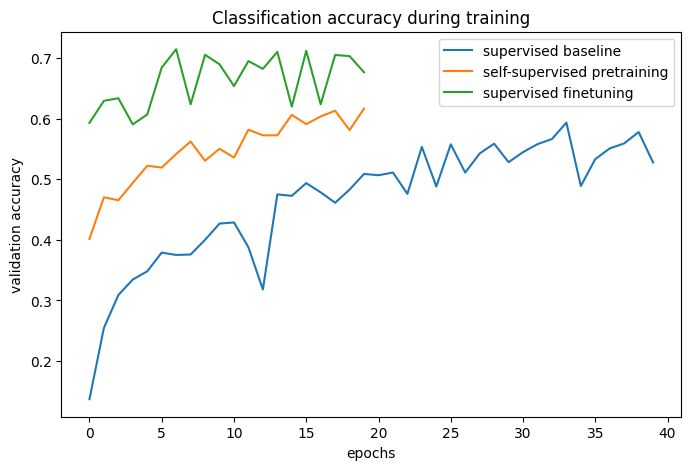

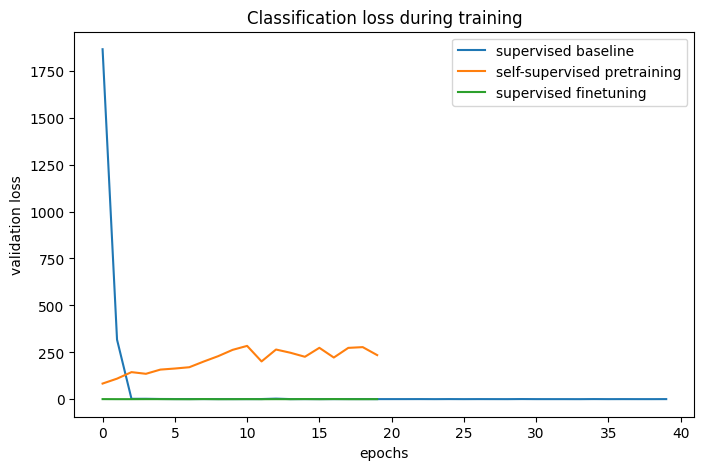

In [18]:
# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"],
            label="supervised baseline",
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)